In [1]:
import croissant as cro

from astropy.units import s as seconds
import healpy as hp
from lunarsky import Time
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

### Load beams and sky

In [2]:
d = np.load("freespace.npz")
freqs = d["freqs"]
sbeam_alm = d["synthesized_beam"]

b = np.load("/home/christian/Documents/research/eigsep/eigsep_sims/eigsep_bowtie_v000.npz")
beam = b["bm"][:-1]
nside = b["nside"]
npix = hp.nside2npix(nside)
beam /= np.sum(beam*4*np.pi/npix, axis=1, keepdims=True)
lmax = 2*nside
beam_hp = cro.HealpixMap(beam, frequencies=freqs, coord="T")
beam = cro.Beam.from_healpix(beam_hp)

# we did an lmax cut to save memory, have to add it back with zero-padding
sbeam_alm_full = np.zeros((len(freqs), hp.Alm.getsize(lmax)), dtype=complex)
sbeam_alm_full[:, :sbeam_alm.shape[1]] = sbeam_alm
sbeam_alm = sbeam_alm_full
sbeam = cro.Beam(sbeam_alm, lmax=lmax, frequencies=freqs, coord="T")

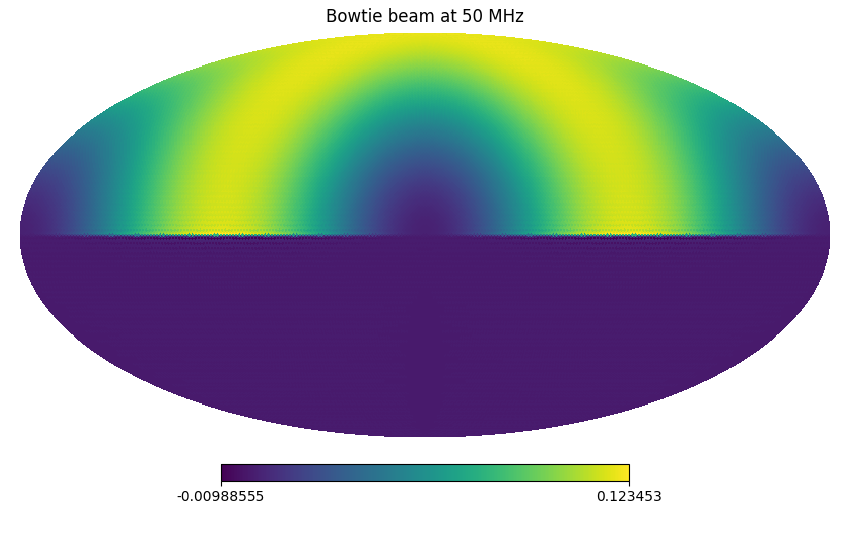

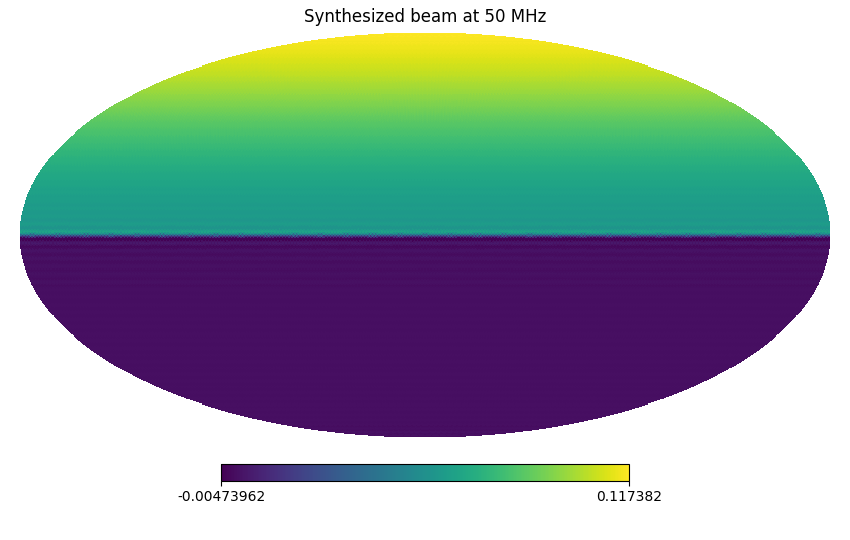

In [4]:
# we can impose a horizon like this, note that the sharp edge creates ripples since we don't have an inifinite lmax
beam.horizon_cut()
hp.mollview(beam.hp_map(nside)[0], title=f"Bowtie beam at {freqs[0]:.0f} MHz")

sbeam.horizon_cut()
hp.mollview(sbeam.hp_map(nside)[0], title=f"Synthesized beam at {freqs[0]:.0f} MHz")

We use the Global Sky Model (Zheng et al 2016) at 25 MHz as the sky model. It has a built-in interface in the sky module of croissant.

In [5]:
sky = cro.Sky.gsm(beam.frequencies, lmax=beam.lmax)

## Prepare and run simulators

In [6]:
# a full sidereal day at Marjum
loc = (-113.4033, 39.2477)
t_start = Time("2026-07-10 15:43:43")
t_end = t_start + cro.constants.sidereal_day_earth * seconds
times = cro.utils.time_array(t_start=t_start, t_end=t_end, N_times=300)

# one sim for regular bowtie beam, one for synthesized
sim = cro.Simulator(beam, sky, lmax=lmax, world="earth", location=loc, times=times)
sim_synth = cro.Simulator(sbeam, sky, lmax=lmax, world="earth", location=loc, times=times)

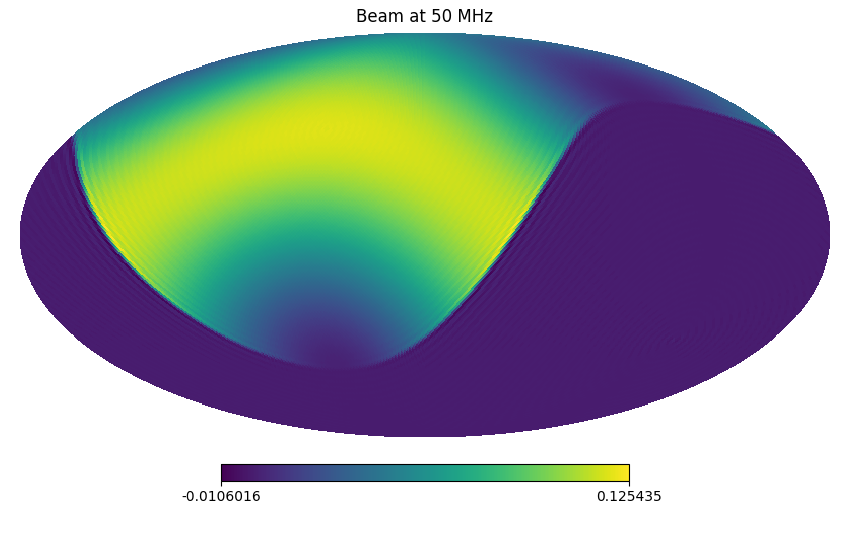

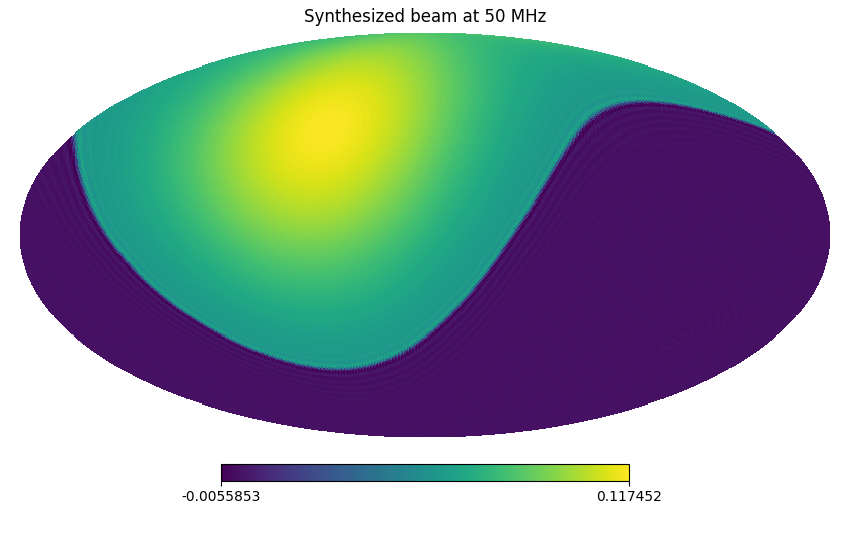

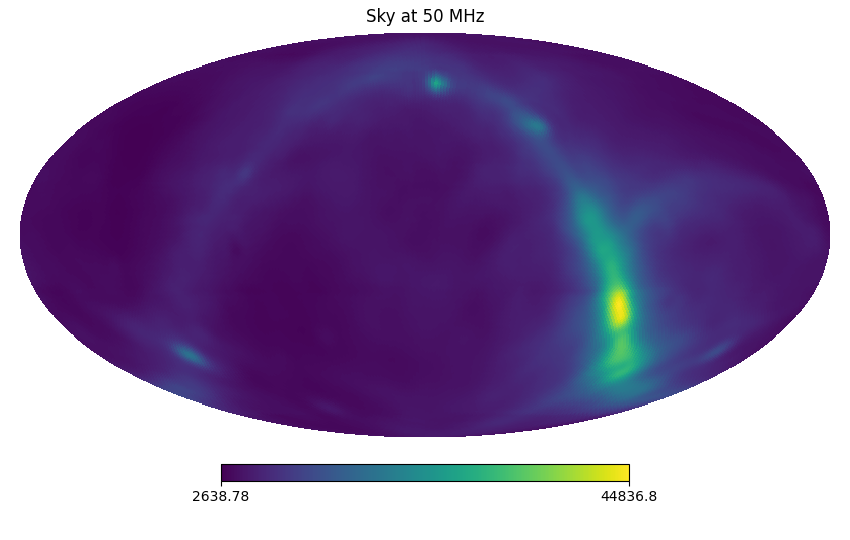

In [7]:
# the simulator view of the beam and sky after moving to equatorial coordinates
hp.mollview(sim.beam.hp_map(nside)[0], title=f"Beam at {freqs[0]:.0f} MHz")
hp.mollview(sim_synth.beam.hp_map(nside)[0], title=f"Synthesized beam at {freqs[0]:.0f} MHz")
hp.mollview(sim.sky.hp_map(nside)[0], title=f"Sky at {freqs[0]:.0f} MHz")

Run the simulators!

In [8]:
def plot_diff(sim1, sim2, figsize=None, extent=None, vmin=None, vmax=None):
    """
    Plot difference between two waterfalls. Assuming they have the same times/freqs.
    """
    if sim1.times[0] == 0:
        time_label = "Time [hours]"
    else:
        t_start = sim1.times[0].to_value("iso", subfmt="date_hm")
        time_label = f"Hours since {t_start}"
    plt.figure(figsize=figsize)
    if extent is None:
        extent = [sim1.frequencies.min(), sim1.frequencies.max(), sim1.dt[-1] / 3600, 0]
    plt.imshow(
        sim1.waterfall - sim2.waterfall, extent=extent, aspect="auto", interpolation="none", vmin=vmin, vmax=vmax
    )
    plt.colorbar(label="Temperature [K]")
    plt.xlabel("Frequency [MHz]")
    plt.ylabel(time_label)
    plt.show() 

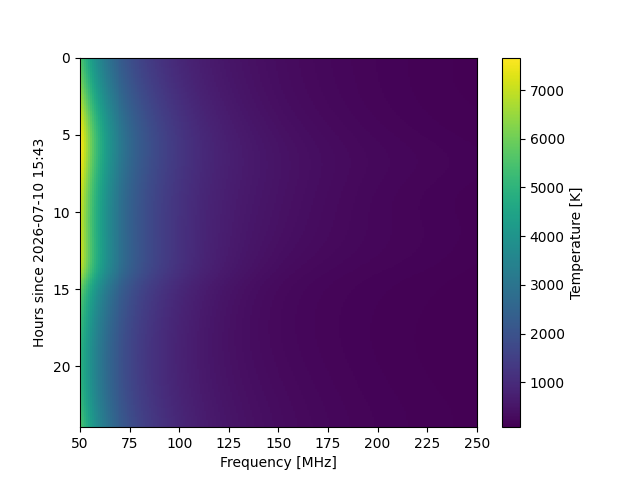

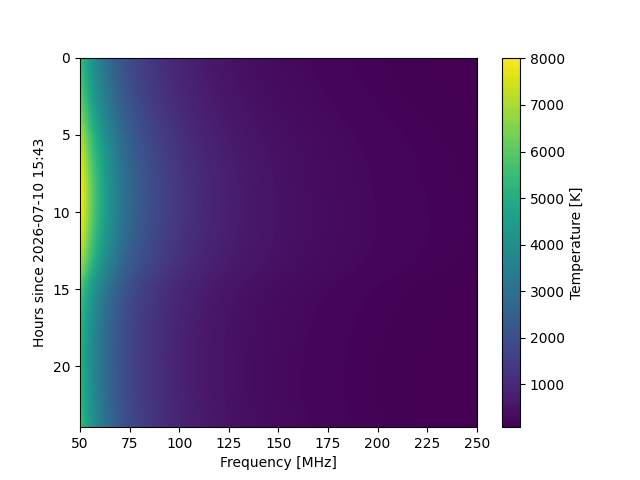

In [9]:
sim.run(dpss=False)
sim.plot()

sim_synth.run(dpss=False)
sim_synth.plot()

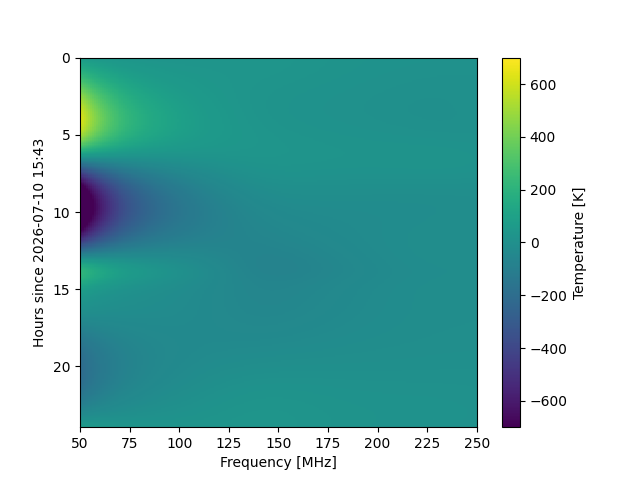

In [10]:
plot_diff(sim, sim_synth, vmin=-700, vmax=700)

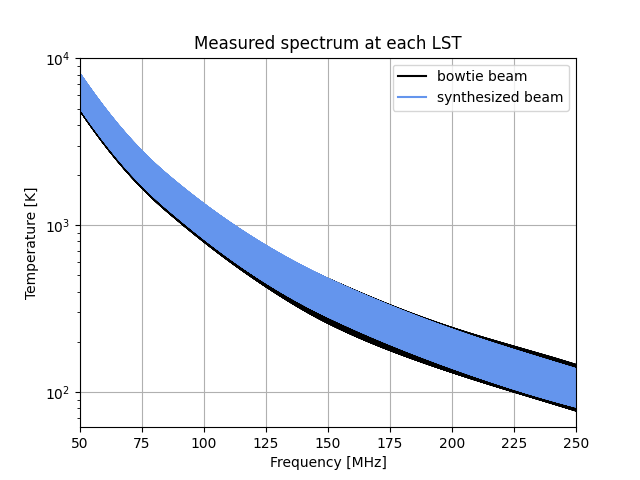

In [11]:
plt.figure()
plt.plot(sim.frequencies, sim.waterfall.T, ls="-", c="k")
l1 = plt.gca().lines[-1]
plt.plot(sim.frequencies, sim_synth.waterfall.T, ls="-", c="cornflowerblue")
l2 = plt.gca().lines[-1]
plt.xlim(sim.frequencies.min(), sim.frequencies.max())
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [K]")
plt.legend([l1, l2], ["bowtie beam", "synthesized beam"])
plt.grid()
plt.yscale("log")
plt.title("Measured spectrum at each LST")
plt.show()

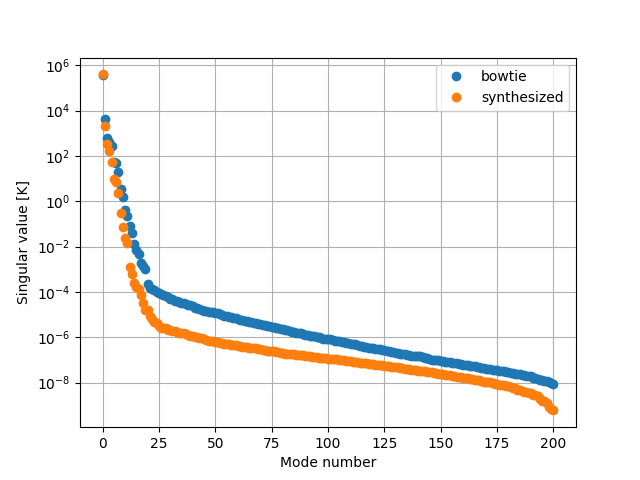

In [12]:
ub, sb, vhb = np.linalg.svd(sim.waterfall)  # bowtie
us, ss, vhs = np.linalg.svd(sim_synth.waterfall)  # synthesized

plt.figure()
plt.plot(sb, ls="none", marker="o", label="bowtie")
plt.plot(ss, ls="none", marker="o", label="synthesized")
plt.yscale("log")
plt.grid()
plt.legend()
plt.ylabel("Singular value [K]")
plt.xlabel("Mode number")
plt.show()

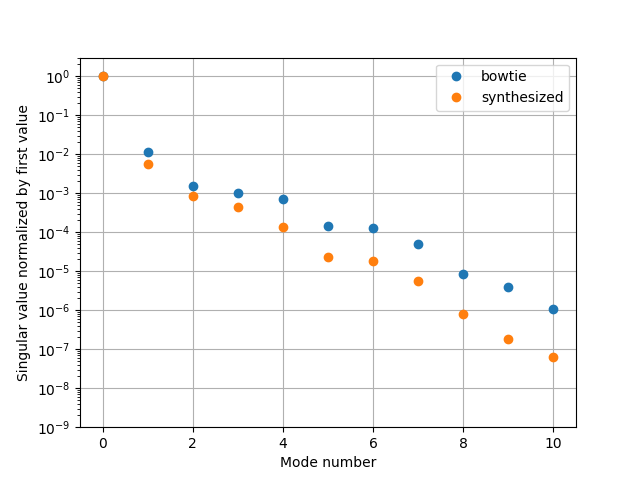

In [13]:
plt.figure()
plt.plot(sb/sb[0], ls="none", marker="o", label="bowtie")
plt.plot(ss/ss[0], ls="none", marker="o", label="synthesized")
plt.yscale("log")
plt.grid()
plt.legend()
plt.ylabel("Singular value normalized by first value")
plt.xlabel("Mode number")
plt.xlim(-.5, 10.5)
plt.ylim(1e-9, 3)
plt.show()

## Overlap wth 21cm models

In [14]:
from scipy.interpolate import interp1d

In [15]:
m21 = np.load("models_21cm.npz")
m21_f = m21["freqs"] * 1e3
m21_t = m21["models"]

In [16]:
t21 = np.empty((len(m21_t), len(freqs)), dtype=float)
for i, mdl in enumerate(m21_t):
    spline = interp1d(m21_f, mdl, kind="cubic", fill_value="extrapolate")
    t21[i] = spline(freqs)

t21 /= 1e3  # mK to K

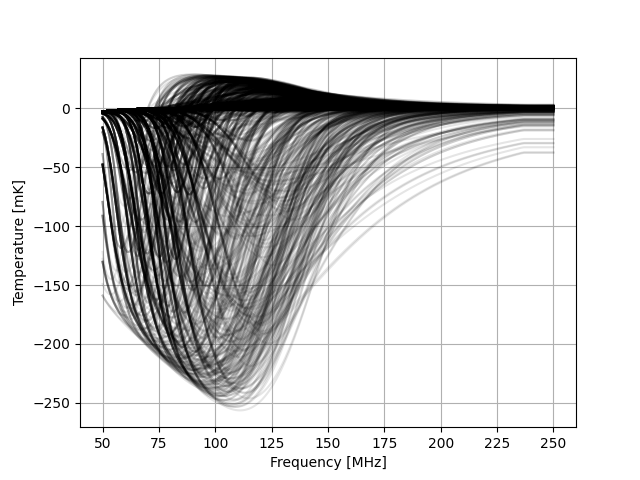

In [17]:
plt.figure()
plt.plot(freqs, t21.T * 1e3, c="k", alpha=0.1)
plt.grid()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [mK]")
plt.show()

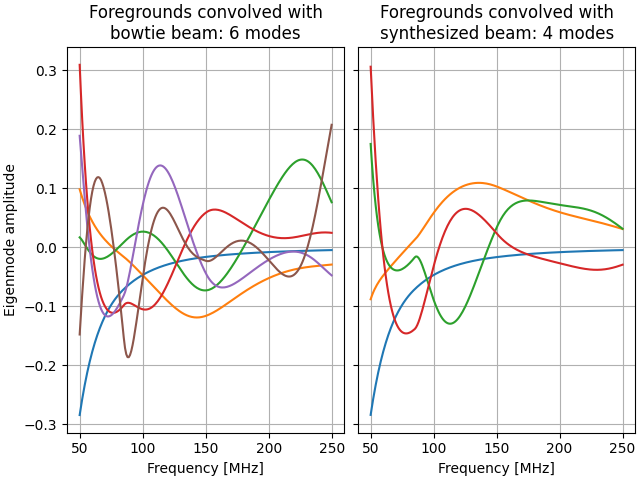

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, constrained_layout=True)
axs[0].plot(freqs, vhb[:6].T)
axs[1].plot(freqs, vhs[:4].T)

axs[0].set_ylabel("Eigenmode amplitude")
plt.setp(axs, xlabel="Frequency [MHz]")

axs[0].set_title("Foregrounds convolved with\nbowtie beam: 6 modes")
axs[1].set_title("Foregrounds convolved with\nsynthesized beam: 4 modes")

axs[0].grid()
axs[1].grid()

plt.show()

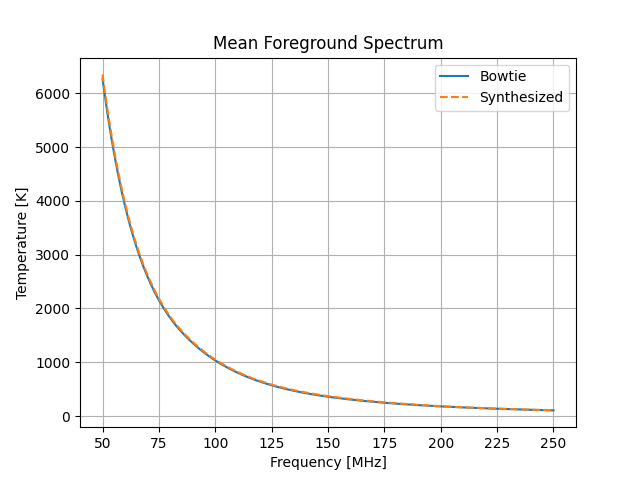

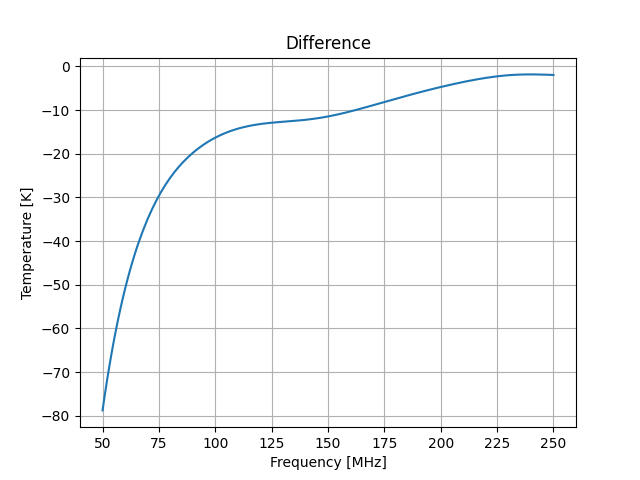

In [19]:
plt.figure()
plt.plot(freqs, sim.waterfall.mean(axis=0), label="Bowtie")
plt.plot(freqs, sim_synth.waterfall.mean(axis=0), label="Synthesized", ls="--")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [K]")
plt.grid()
plt.legend()
plt.title("Mean Foreground Spectrum")
plt.show()

plt.figure()
plt.plot(freqs, sim.waterfall.mean(axis=0) - sim_synth.waterfall.mean(axis=0))
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [K]")
plt.grid()
plt.title("Difference")
plt.show()

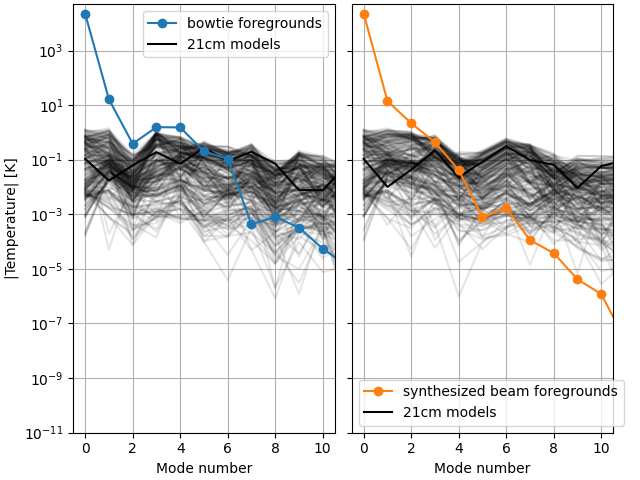

In [20]:
modes = np.arange(len(vhb))

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, constrained_layout=True)
axs[0].plot(modes, np.abs(t21@vhb.T)[::5].T, c="k", alpha=0.1)
l21 = axs[0].lines[-1]
l21.set_alpha(1)
axs[0].plot(modes, np.abs(sim.waterfall.mean(axis=0) @ vhb.T), marker="o")
lfg = axs[0].lines[-1]
axs[0].legend([lfg, l21], ["bowtie foregrounds", "21cm models"])

axs[1].plot(modes, np.abs(t21@vhs.T)[::5].T, c="k", alpha=0.1)
l21 = axs[1].lines[-1]
l21.set_alpha(1)
axs[1].plot(modes, np.abs(sim_synth.waterfall.mean(axis=0) @ vhs.T), marker="o", c="C1")
lfg = axs[1].lines[-1]
axs[1].legend([lfg, l21], ["synthesized beam foregrounds", "21cm models"])

plt.setp(axs, yscale="log", xlabel="Mode number", xlim=(-0.5, 10.5), ylim=(1e-11, 5e4))

axs[0].set_ylabel("|Temperature| [K]")
axs[0].grid()
axs[1].grid()

plt.show()

The above plots show how we might hope to detect the cosmological signal when using the synthesized beam. If we filter 3-5 modes, the cosmological signal dominates the foregrounds. With the regular bowtie, we might have to filter 8-10 modes, and even then, the dynamic range is not as good.

There's a subtle difficulty: above, we generated the eigenmodes from foregrounds only. In practice, the eignemodes will contain the cosmological signal unless we subtract the mean. But subtracting the mean does not work since we won't be able to remove much foreground power. We may have to construct the modes from simulations.

## How to do it in practice

It's difficult to construct eigenmodes from simulations in an honest way when the synthetic data is generated from the same simulations. This wouldn't be a problem with real data of course. An option is to use distinct foreground models for simulation and fitting (e.g., GSM and GMOSS). For now, let's just try create the modes with the signal in it.

In [21]:
#rng = np.random.default_rng(seed=0)
rng = np.random.default_rng(seed=10)
true_t21 = rng.choice(t21)

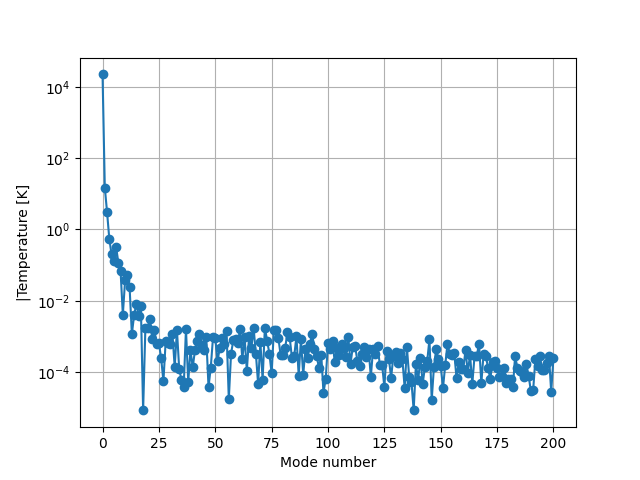

In [23]:
dat_synth = sim_synth.waterfall + true_t21[None]
#u_ds, s_ds, vh_ds = np.linalg.svd(dat_synth)

mean_synth = dat_synth.mean(axis=0)
plt.figure()
plt.plot(modes, np.abs(mean_synth @ vhs.T), marker="o")
plt.xlabel("Mode number")
plt.ylabel("|Temperature [K]")
plt.yscale("log")
plt.grid()
plt.show()

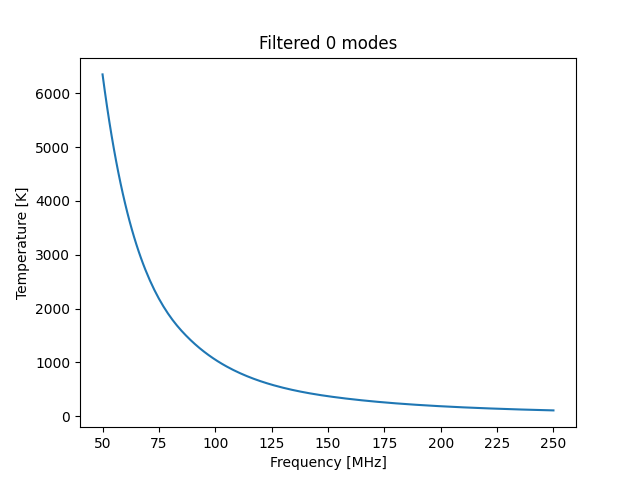

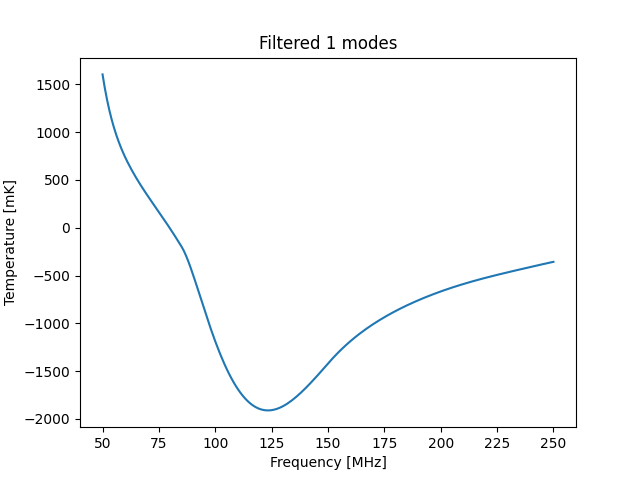

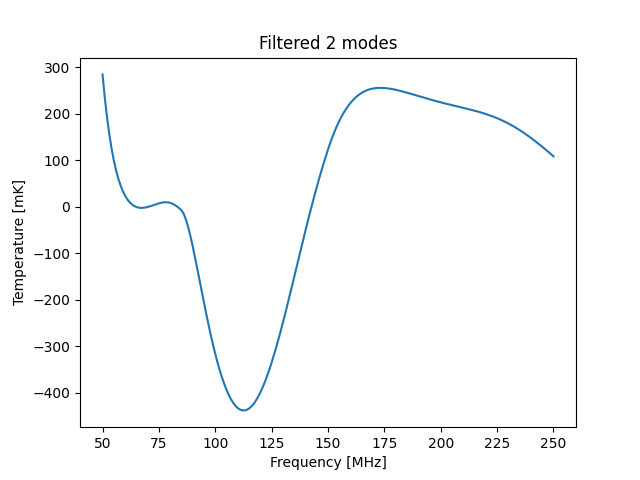

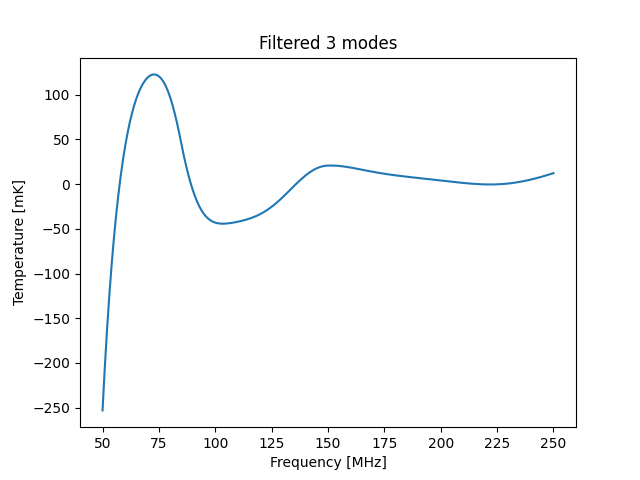

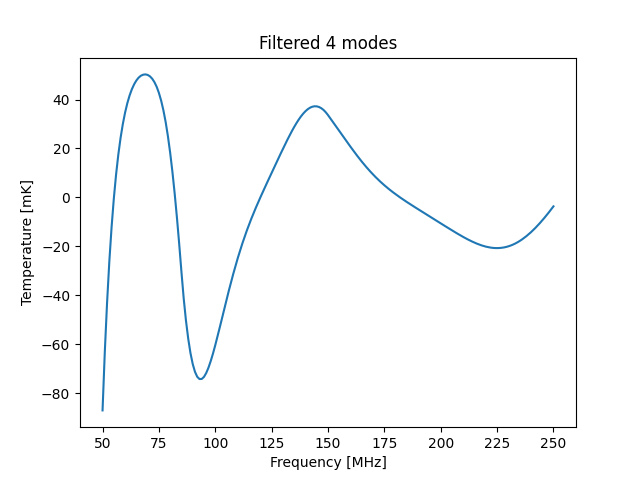

In [24]:
for i in range(5):
    _m = mean_synth @ vhs.T
    _m[:i] = 0
    filt = _m @ vhs
    if i > 0:
        filt *= 1e3
        unit = "mK"
    else:
        unit = "K"
    plt.figure()
    plt.plot(freqs, filt)
    plt.title(f"Filtered {i} modes")
    plt.xlabel("Frequency [MHz]")
    plt.ylabel(f"Temperature [{unit}]")
    plt.show()

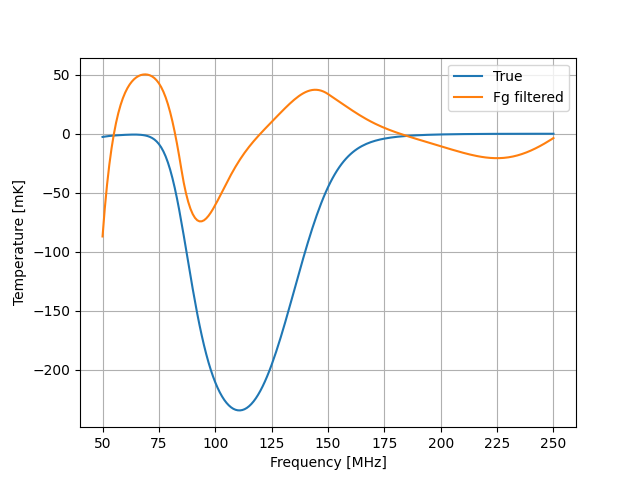

In [27]:
_m = mean_synth @ vhs.T
_m[:4] = 0
filt = _m @ vhs

plt.figure()
plt.plot(freqs, true_t21*1e3, label="True")
plt.plot(freqs, filt*1e3, label="Fg filtered")
plt.legend()
plt.grid()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [mK]")
plt.show()

Let's be conservative and say that modes where foregrounds dominate should just be eliminated. In this case (no data), we have to resort to priors. Essentially, our likelihood is a step function from 0 to 1 at the mode cutoff. In reality, you want to be a bit more sophisticated! Note also that the signal is particularly easy to measure.

(1135, 201)


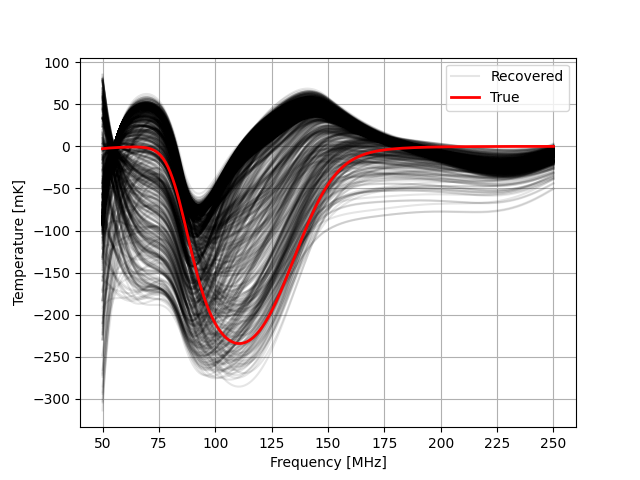

In [28]:
# don't know what the filtered modes are so just use the priors
_mpr = np.repeat(_m[None], len(t21), axis=0)  # copy measured modes
_mpr[:, :4] = (t21 @ vhs.T)[:, :4]  # fill in priors for the unmeasured modes
rec_t21 = _mpr @ vhs

print(rec_t21.shape)

plt.figure()
plt.plot(freqs, rec_t21[0]*1e3, label="Recovered", c="k", alpha=0.1)
plt.plot(freqs, rec_t21[1:].T*1e3, c="k", alpha=0.1)
plt.plot(freqs, true_t21*1e3, label="True", c="red", lw=2)
plt.legend()
plt.grid()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [mK]")
plt.show()

What if our prior was just the true signal?

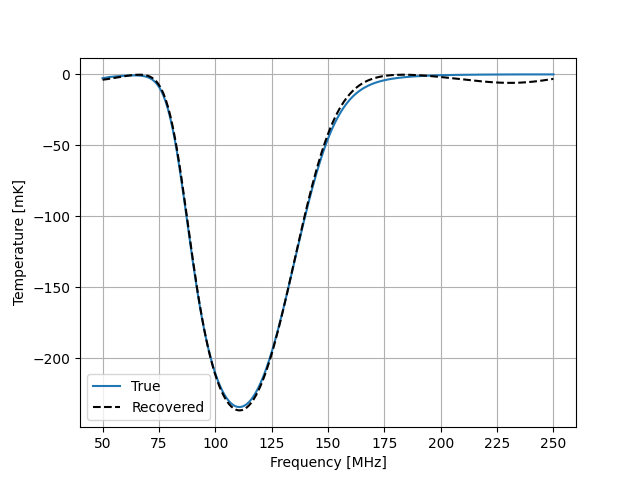

In [30]:
# don't know what the filtered modes are so just use the priors
_mpr_t = np.copy(_m)  # copy measured modes
#_mpr_t[:10] = (true_t21 @ vhs.T)[:10]  # fill in priors for the unmeasured modes
_mpr_t[:4] = (true_t21 @ vhs.T)[:4]  # fill in priors for the unmeasured modes
rec_t21_t = _mpr_t @ vhs

plt.figure()
plt.plot(freqs, true_t21*1e3, label="True")
plt.plot(freqs, rec_t21_t*1e3, label="Recovered", c="k", ls="--")
plt.legend()
plt.grid()
plt.xlabel("Frequency [MHz]")
plt.ylabel("Temperature [mK]")
plt.show()